# Problem statement:
###### Build a model to classify emails into different categories based on the content of the emails.
###### Data: "A subset of about 1700 labelled email messages" from https://bailando.berkeley.edu/enron_email.html

# Approach:
###### 1. Clean the dataset with stemming, removing stopwords, numerals etc.
###### 2. Prepare the corpus and learn Doc2Vec embeddings with (PV-DBOW).
###### 3. Implement a simple Feed Forward Neural network with dropout and L2 regularization.
###### 4. Take learnt embeddings as the input to the Model and fine tune the network.
###### 4. Data is imbalanced. Used balanced class weights during trainning.

### NOTE:
###### 1. Insight: for data imbalance, few shot learning, similarity between the documents and Siamese network of RNNs can be explored. Refer: my previous [work](https://github.com/Prateedk/One-Shot-Classification/blob/main/OneShotClassificationProjectReport.pdf) on this.
###### 2. As data set is small, this objective can be achieved with the use of tfidf feature extraction, LDA, BoW models etc. This approach is adapted so that it would work on wider problems as well.
###### 3. SOTA Transformer encoder architectures such as BERT can also be used with its vector-space representations, but that would be a overkill as per data and objective.
###### 4. There is high scope of Code Modularization, this is just a draft. So that, one can easily understand the approach.

# Importing Libraries

In [2]:
#!nvidia-smi

In [3]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

# Download and Unzip dataset

In [4]:
!wget https://bailando.berkeley.edu/enron/enron_with_categories.tar.gz
import tarfile
fname = 'enron_with_categories.tar.gz'
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

for dirpath, dirnames, filenames in os.walk("enron_with_categories/"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} textfiles in '{dirpath}'.") 

--2022-11-28 05:06:03--  https://bailando.berkeley.edu/enron/enron_with_categories.tar.gz
Resolving bailando.berkeley.edu (bailando.berkeley.edu)... 128.32.78.19
Connecting to bailando.berkeley.edu (bailando.berkeley.edu)|128.32.78.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4523350 (4.3M) [application/x-gzip]
Saving to: ‘enron_with_categories.tar.gz’

enron_with_categori 100%[===================>]   4.31M  --.-KB/s    in 0.1s    

2022-11-28 05:06:04 (29.1 MB/s) - ‘enron_with_categories.tar.gz’ saved [4523350/4523350]

there are 8 directories and 1 textfiles in 'enron_with_categories/'.
there are 0 directories and 72 textfiles in 'enron_with_categories/2'.
there are 0 directories and 286 textfiles in 'enron_with_categories/6'.
there are 0 directories and 148 textfiles in 'enron_with_categories/5'.
there are 0 directories and 42 textfiles in 'enron_with_categories/7'.
there are 0 directories and 952 textfiles in 'enron_with_categories/4'.
there are 0 di

# Remove the classes

Deleting the classes 7 and 8

In [5]:
import shutil
directory = 'enron_with_categories/7'
shutil.rmtree(directory)
directory = 'enron_with_categories/8'
shutil.rmtree(directory)

# Split the dataset
###### Split in the ratio of *train : val : test = 0.8 : 0.1 : 0.1*

In [6]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import splitfolders
splitfolders.ratio('enron_with_categories', output="enron_with_categories_split", seed=32, ratio=(.8, 0.1, 0.1)) 

Copying files: 3326 files [00:00, 8524.45 files/s]


In [8]:
!ls enron_with_categories_split

test  train  val


# Delete cats file

In [9]:
import glob

pattern = r"enron_with_categories_split/*/*/*.cats"
for item in glob.iglob(pattern, recursive=True):
    os.remove(item)

# Class Imbalance
#### The classes are imbalanced and very less data available for classes: 2, 3 and 5
##### Before trainning, need to use class weight in neural network

In [10]:
for dirpath, dirnames, filenames in os.walk("enron_with_categories_split"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} textfiles in '{dirpath}'.") 

there are 3 directories and 0 textfiles in 'enron_with_categories_split'.
there are 6 directories and 0 textfiles in 'enron_with_categories_split/train'.
there are 0 directories and 28 textfiles in 'enron_with_categories_split/train/2'.
there are 0 directories and 113 textfiles in 'enron_with_categories_split/train/6'.
there are 0 directories and 61 textfiles in 'enron_with_categories_split/train/5'.
there are 0 directories and 375 textfiles in 'enron_with_categories_split/train/4'.
there are 0 directories and 673 textfiles in 'enron_with_categories_split/train/1'.
there are 0 directories and 85 textfiles in 'enron_with_categories_split/train/3'.
there are 6 directories and 0 textfiles in 'enron_with_categories_split/test'.
there are 0 directories and 4 textfiles in 'enron_with_categories_split/test/2'.
there are 0 directories and 18 textfiles in 'enron_with_categories_split/test/6'.
there are 0 directories and 8 textfiles in 'enron_with_categories_split/test/5'.
there are 0 directorie

In [11]:
import pathlib
data_dir = pathlib.Path("enron_with_categories_split/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['1' '2' '3' '4' '5' '6']


# Visualize/Read the random data

In [12]:
import random

def view_text(target_dir, target_class):
  target_folder = target_dir+target_class
  random_sample = random.sample(os.listdir(target_folder), 1)
  print(random_sample)

  return random_sample[0]

train_path = "enron_with_categories_split/train/"
class_name = "1/"
r_text = view_text(train_path, class_name)
file1 = open(train_path+class_name+r_text,"r+") 
  
#print(file1.read())

['136409.txt']


# Import libraries to clean and tokenize the data

In [13]:
import gensim
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from os import listdir
from os.path import isfile, join

# Create list of train,val,test: data and labels

In [14]:
#now create a list that contains the name of all the text file in your data #folder
docLabels = []
data = []
train_data = []
test_data = []
val_data = []
y_train = []
y_test = []
y_val = []

for i in range(1,7):
  path = "enron_with_categories_split/train/" + str(i)
  docLabels = [f for f in listdir(path) if f.endswith('.txt')]

  for doc in docLabels:
    path = 'enron_with_categories_split/train/' + str(i) + '/' + doc
    train_data.append(open(path).read())
    data.append(open(path).read())
    y_train.append(i)

  path = "enron_with_categories_split/test/" + str(i)
  docLabels = [f for f in listdir(path) if f.endswith('.txt')]

  for doc in docLabels:
    path = 'enron_with_categories_split/test/' + str(i) + '/' + doc
    test_data.append(open(path).read())
    data.append(open(path).read())
    y_test.append(i)

  path = "enron_with_categories_split/val/" + str(i)
  docLabels = [f for f in listdir(path) if f.endswith('.txt')]

  for doc in docLabels:
    path = 'enron_with_categories_split/val/' + str(i) + '/' + doc
    val_data.append(open(path).read())
    data.append(open(path).read())
    y_val.append(i)

In [15]:
len(train_data), len(y_train) , len(test_data), len(y_test), len(val_data), len(y_val), len(data)

(1335, 1335, 156, 156, 172, 172, 1663)

# Data Cleaning
##### 1. Change all words to lowercase
##### 2. Remove numbers
##### 3. Use PorterStemmer() for stemming
##### 4. Remove stopwords

In [16]:
import nltk
nltk.download('stopwords')
from nltk.stem.porter import *
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))
#This function does all cleaning of data using two objects above
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def nlp_clean(data):
   new_data = []
   for d in data:
      new_str = d.lower()
      new_str2 = ''.join([i for i in new_str if not i.isdigit()])
      new_str3 = ' '.join([w for w in new_str2.split() if len(w)>3])
      dlist = tokenizer.tokenize(new_str3)
      stemmer = PorterStemmer()
      stemmed = stem_tokens(dlist, stemmer)
      dlist = [w for w in stemmed if not w.lower() in stopword_set]  
      dlist = []
  
      for w in stemmed:
        if w not in stopword_set:
          dlist.append(w)
      new_data.append(dlist)
   return new_data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:
data = nlp_clean(data) # whole corpus data for Doc2Vec Trainnnig
train_data = nlp_clean(train_data)
test_data = nlp_clean(test_data)
val_data = nlp_clean(val_data)


In [18]:
len(data), len(train_data), len(test_data), len(val_data)

(1663, 1335, 156, 172)

# Prepare data for learning Doc2Vec embedding

In [19]:
#trainnin_data means train data for doc2vec
def tagged_document(list_of_list_of_words):
   for i, list_of_words in enumerate(list_of_list_of_words):
      yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])


training_data = list(tagged_document(data))

# Doc2Vec Model 
###### 1. Learn embedding from the prepared corpus with embedding dimension: 512
###### 2. dm=1 was also used to utilize the skip-gram word-vector training with window=2, but results were not significant
###### 3. Tried with lower dimensions as well. Embeddings with < 128 were not good enough and was overfitting in the early iterations
###### 4. Also, trainning is slower with dm=1 as compare to dm=0 (PV-DBOW) which also worked fine. Due to limited time, I went for dm=0

In [20]:
model_pvdbow = gensim.models.doc2vec.Doc2Vec(vector_size=512, epochs=250, dm=0, min_count = 4)


In [21]:
model_pvdbow.build_vocab(training_data)

In [22]:
model_pvdbow.train(training_data, total_examples=model_pvdbow.corpus_count, epochs=model_pvdbow.epochs)

In [23]:
#print(model_pvdbow.infer_vector(['I', 'love', 'natural', 'language', 'processing']))

# Infer the learnt embeddings

In [25]:
X_train = []
X_val = []
X_test = []
for i in range(0,len(train_data)):
  X_train.append(model_pvdbow.infer_vector(train_data[i]))
for i in range(0,len(test_data)):
  X_test.append(model_pvdbow.infer_vector(test_data[i]))
for i in range(0,len(val_data)):
  X_val.append(model_pvdbow.infer_vector(val_data[i]))

In [26]:
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
X_val_np = np.array(X_val)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)
y_val_np = np.array(y_val)
y_train_np = y_train_np.reshape(len(y_train),1)
y_test_np = y_test_np.reshape(len(y_test),1)
y_val_np = y_val_np.reshape(len(y_val),1)

In [27]:
X_train_np.shape, y_train_np.shape, X_test_np.shape, y_test_np.shape, X_val_np.shape, y_val_np.shape

((1335, 512), (1335, 1), (156, 512), (156, 1), (172, 512), (172, 1))

# Prepare One Hot Encoding for the Labels

In [28]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train_np)
y_test = onehot_encoder.fit_transform(y_test_np)
y_val = onehot_encoder.fit_transform(y_val_np)
print(y_train.shape, y_test.shape, y_val.shape)

(1335, 6) (156, 6) (172, 6)


In [29]:
X_train_np.shape

(1335, 512)

# Balancing the Class weights
##### Generate the class_weights to balance the data

In [30]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=True):
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))

In [31]:
class_weights = generate_class_weights(y_train)

# Shuffle the data



In [32]:
from sklearn.utils import shuffle
X_train_np, y_train = shuffle(X_train_np,y_train)

# Neural Network
#### Simple Feed Forward NN with:
##### 1. 6 hidden layers
##### 2. Dropout of 0.5 as Model tends to overfit
##### 3. Add l2 regularization on weights to avoid overfit
##### 4. activation function in each layer is 'elu'
###### Note: Even with less parameters, Model works just fine (As the dataset is very small) 

In [33]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
inputs = layers.Input(shape=(512,))
x = layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.01))(inputs)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(rate=0.5)(x)
x = layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.01))(x)
outputs = layers.Dense(6,activation='softmax')(x)
model3 = tf.keras.Model(inputs,outputs,name="model_1_dense")

model3.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)             

# Model details
##### 1. loss: CategoricalCrossentropy
##### 2. optimizer: Adam with learning rate: 0.0001 (Tried with default:0.001 but observed fluctuations and was not converging)

In [34]:
import tensorflow
METRICS = [
      'accuracy',
      tensorflow.keras.metrics.FalsePositives(name='fp'),
      tensorflow.keras.metrics.FalseNegatives(name='fn'),
]

model3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics = METRICS
)

# Model fit
##### 1. batch_size = 64
##### 2. epochs = 275
##### 3. Use class_weights to pass balanced data

In [35]:
model_history = model3.fit(X_train_np,
                              y_train,
                              batch_size=64,
                              epochs=275,
                              class_weight = class_weights,
                              validation_data=(X_val_np, y_val)
)

Epoch 1/275
21/21 [==============================] - 4s 25ms/step - loss: 32.7823 - accuracy: 0.1468 - fp: 312.0000 - fn: 1275.0000 - val_loss: 32.1775 - val_accuracy: 0.1628 - val_fp: 0.0000e+00 - val_fn: 172.0000
Epoch 2/275
21/21 [==============================] - 0s 7ms/step - loss: 32.3605 - accuracy: 0.1865 - fp: 279.0000 - fn: 1274.0000 - val_loss: 31.8922 - val_accuracy: 0.2616 - val_fp: 0.0000e+00 - val_fn: 172.0000
Epoch 3/275
21/21 [==============================] - 0s 7ms/step - loss: 32.0090 - accuracy: 0.1805 - fp: 247.0000 - fn: 1280.0000 - val_loss: 31.6162 - val_accuracy: 0.2558 - val_fp: 0.0000e+00 - val_fn: 172.0000
Epoch 4/275
21/21 [==============================] - 0s 6ms/step - loss: 31.6589 - accuracy: 0.2015 - fp: 229.0000 - fn: 1279.0000 - val_loss: 31.2994 - val_accuracy: 0.2965 - val_fp: 0.0000e+00 - val_fn: 172.0000
Epoch 5/275
21/21 [==============================] - 0s 6ms/step - loss: 31.3429 - accuracy: 0.2157 - fp: 179.0000 - fn: 1282.0000 - val_loss: 

# Evaluate the model on test set
Achieved Accuracy: 71.79

In [36]:
model3.evaluate(X_test_np,y_test)

5/5 [==============================] - 0s 4ms/step - loss: 1.7362 - accuracy: 0.7179 - fp: 43.0000 - fn: 51.0000


[1.7362176179885864, 0.7179487347602844, 43.0, 51.0]

In [37]:
ans = model3.predict(X_test_np)

5/5 [==============================] - 0s 2ms/step


In [38]:
final_ans = np.argmax(ans,axis=1) + 1
final_y_test = np.argmax(y_test,axis=1) + 1

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(final_y_test,final_ans)
cm

array([[53,  0,  4,  7,  0,  3],
       [ 2,  2,  0,  0,  0,  0],
       [ 2,  1,  4,  1,  1,  0],
       [ 6,  0,  2, 40,  1,  1],
       [ 2,  0,  2,  1,  2,  1],
       [ 3,  0,  0,  2,  2, 11]])

# Plots
#### 1. Plotting False-Positives and False-Negatives as data is imbalance

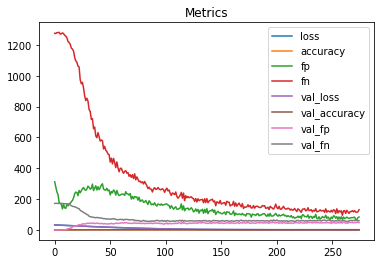

In [40]:
import matplotlib.pyplot as plt
pd.DataFrame(model_history.history).plot(title="Metrics")

#### 2. Model Loss curve

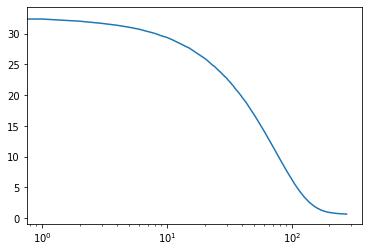

In [44]:
Epochs = tf.range(275)
plt.semilogx(Epochs, model_history.history["loss"])

# Confusion Matrix
##### Confusion mat on test set 

In [42]:
import itertools
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

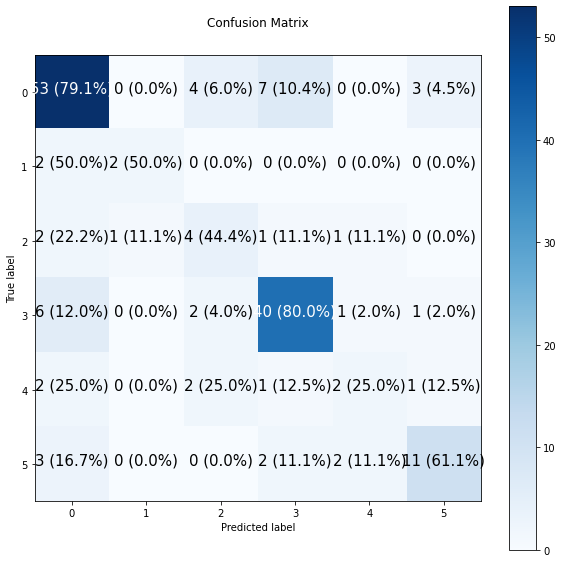

In [43]:
make_confusion_matrix(final_y_test, final_ans)